In [21]:
import sys
import os
sys.path.insert(0,'Z:/Cristina/Section3/NME_DEC')
sys.path.insert(0,'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels')

import mxnet as mx
import numpy as np
import pandas as pd

from utilities import *
import data
import model
from autoencoder import AutoEncoderModel
from solver import Solver, Monitor
import logging

from sklearn.manifold import TSNE
from utilities import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import sklearn.neighbors 
import matplotlib.patches as mpatches
from sklearn.utils.linear_assignment_ import linear_assignment

try:
   import cPickle as pickle
except:
   import pickle
import gzip

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

#####################################################
#####################################################
## 1) read in the datasets both all NME (to do pretraining)
NME_nxgraphs = r'Z:\Cristina\Section3\breast_MR_NME_biological\NMEs_SER_nxgmetrics'
    
allNMEs_dynamic = pd.read_csv(os.path.join(NME_nxgraphs,'dyn_roi_records_allNMEs_descStats.csv'), index_col=0)
   
allNMEs_morphology = pd.read_csv(os.path.join(NME_nxgraphs,'morpho_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_texture = pd.read_csv(os.path.join(NME_nxgraphs,'text_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_stage1 = pd.read_csv(os.path.join(NME_nxgraphs,'stage1_roi_records_allNMEs_descStats.csv'), index_col=0)

# to load SERw matrices for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    nxGdatafeatures = pickle.load(fin)

# to load discrall_dict dict for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGnormfeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    discrall_dict_allNMEs = pickle.load(fin)         

######### 1) fiest create datasets with only traditional CAD features
# shape input (798L, 197L)    
combtrCAD_allNME = np.concatenate((allNMEs_dynamic.as_matrix(), allNMEs_morphology.as_matrix(), allNMEs_texture.as_matrix(), allNMEs_stage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} combtrCAD_allNME of size = {}'.format(combtrCAD_allNME.shape[0], combtrCAD_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )

######### 2) combine with graphf datasets
# shape input (798L, 197L)    
combX_allNME = np.concatenate((discrall_dict_allNMEs, allNMEs_dynamic.as_matrix(), allNMEs_morphology.as_matrix(), allNMEs_texture.as_matrix(), allNMEs_stage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )


Loading 792 combtrCAD_allNME of size = 197
Loading all NME lables [label,BIRADS,dist,enh] of size = 792
Loading 792 all NME of size = 523
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


In [22]:
######### 3) train/test splits (test is 10% of labeled data)
# remove unlabeled combX_allNME
X = combtrCAD_allNME[YnxG_allNME[1]!='U']
y = np.asarray(YnxG_allNME[1][YnxG_allNME[1]!='U']=='M').astype(int)

sep = int(combtrCAD_allNME.shape[0]*0.10)
X_test = X[:sep]
y_test = y[:sep]
X_train = X[sep:]
y_train = y[sep:]
batch_size = 125 # 160 32*5 = update_interval*5
X_test[np.isnan(X_test)] = 0.00001

# random search of optimal params

In [23]:
######################################################################### for random search
# build a classifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from time import time

clf = RandomForestClassifier()

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"n_estimators": [20,50,100,250,500],
              "max_depth": [3,5,10,None],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)


RandomizedSearchCV took 35.21 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.755 (std: 0.032)
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 50, 'criterion': 'entropy', 'min_samples_split': 3, 'max_depth': 10}

Model with rank: 2
Mean validation score: 0.752 (std: 0.021)
Parameters: {'bootstrap': True, 'min_samples_leaf': 9, 'n_estimators': 250, 'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.748 (std: 0.029)
Parameters: {'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 250, 'criterion': 'entropy', 'min_samples_split': 6, 'max_depth': None}



In [24]:
######################################################################### for grid parameters
gn_estimators= [20,50,100,250,500]
gmax_depth = [3,10]
gmin_samples_split = [3, 9]
gmin_samples_leaf= [3, 6]

grd = np.array([(d, T, ss, sl) 
            for d in gmax_depth for T in gn_estimators 
            for ss in gmin_samples_split 
            for sl in gmin_samples_leaf ])

grdperf_RF = pd.DataFrame(grd)
grdperf_RF.columns = ["D","ntrees","min_samples_split","min_samples_leaf"]
grdperf_RF['avaucTrain']=0
grdperf_RF['stdTrain']=0
grdperf_RF['avaucVal']=0
grdperf_RF['stdVal']=0
grdperf_RF['auctest']=0
 
# Evaluate a score by cross-validation
sns.set_style("whitegrid")
sns.set_color_codes("pastel")

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, random_state=3)
for k in range(len(grdperf_RF)):  
    # get grid search cell
    D=grdperf_RF["D"].iloc[k]
    ntrees=grdperf_RF["ntrees"].iloc[k]
    min_ss=grdperf_RF["min_samples_split"].iloc[k]
    min_sl=grdperf_RF["min_samples_leaf"].iloc[k]
    # Build in l
    cvAUC_train = []
    cvAUC_val = []
    cvAUC_test = []
    cvi = 0
    for train, val in cv.split(X_train, y_train):
        RFmodel = RandomForestClassifier(bootstrap=True,
                                         criterion='gini',
                                         n_estimators=ntrees,
                                         max_depth=D,
                                         min_samples_split= min_ss,
                                         min_samples_leaf= min_sl,
                                         n_jobs=2, random_state=0, verbose=0)
        # run feature selection
        RF = RFmodel.fit(X_train[train], y_train[train])
        ind_featImp = np.argsort(RF.feature_importances_)[::-1]
        RFvarImp = ind_featImp[np.sort(RF.feature_importances_)[::-1]>0.0]
        # top 20% features only = 523*0.20
        varDiscrim = X_train[:,RFvarImp]
    
        RF = RFmodel.fit(varDiscrim[train], y_train[train])
        probas_train = RF.predict_proba(varDiscrim[train])
        probas_val = RF.predict_proba(varDiscrim[val])
        # Compute ROC curve and area the curve
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train[train], probas_train[:, 1])
        fpr_val, tpr_val, thresholds_val = roc_curve(y_train[val], probas_val[:, 1])
        # do in test
        probas_test = RF.predict_proba( X_test[:,RFvarImp] )
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:, 1])
        auctest = auc(fpr_test, tpr_test)
        # auc
        cvAUC_train.append( auc(fpr_train, tpr_train) )
        cvAUC_val.append( auc(fpr_val, tpr_val) )
        cvAUC_test.append(auctest)
        print "ROC_train$auc = {}".format(cvAUC_train[cvi])
        print "ROC_val$auc = {}".format(cvAUC_val[cvi])
        cvi += 1
    grdperf_RF["avaucTrain"].iloc[k] = np.mean(cvAUC_train)
    grdperf_RF["stdTrain"].iloc[k] = np.std(cvAUC_train)
    grdperf_RF["avaucVal"].iloc[k] = np.mean(cvAUC_val)
    grdperf_RF["stdVal"].iloc[k] = np.std(cvAUC_val)
    grdperf_RF['auctest'].iloc[k] = np.mean(cvAUC_test)

# print
print(grdperf_RF)

ROC_train$auc = 0.921784682081
ROC_val$auc = 0.66577540107
ROC_train$auc = 0.895598043575
ROC_val$auc = 0.747159090909
ROC_train$auc = 0.922015915119
ROC_val$auc = 0.662790697674
ROC_train$auc = 0.914500442087
ROC_val$auc = 0.59738372093
ROC_train$auc = 0.909814323607
ROC_val$auc = 0.603197674419
ROC_train$auc = 0.906882225434
ROC_val$auc = 0.661096256684
ROC_train$auc = 0.870875944864
ROC_val$auc = 0.643465909091
ROC_train$auc = 0.900353669319
ROC_val$auc = 0.643895348837
ROC_train$auc = 0.905481874447
ROC_val$auc = 0.675872093023
ROC_train$auc = 0.897524314766
ROC_val$auc = 0.623546511628
ROC_train$auc = 0.901553468208
ROC_val$auc = 0.70320855615
ROC_train$auc = 0.889550911516
ROC_val$auc = 0.6875
ROC_train$auc = 0.907073386384
ROC_val$auc = 0.656976744186
ROC_train$auc = 0.900884173298
ROC_val$auc = 0.640988372093
ROC_train$auc = 0.907648099027
ROC_val$auc = 0.607558139535
ROC_train$auc = 0.906882225434
ROC_val$auc = 0.661096256684
ROC_train$auc = 0.870875944864
ROC_val$auc = 0.6434

In [25]:
################
# select best grid parameters
index = grdperf_RF[grdperf_RF["avaucVal"] == max(grdperf_RF["avaucVal"])]
print(index)
Dmax = index["D"].iloc[0]
nTmax = index["ntrees"].iloc[0]
min_ssmax = index["min_samples_split"].iloc[0]
min_slmax = index["min_samples_leaf"].iloc[0]

     D  ntrees  min_samples_split  min_samples_leaf  avaucTrain  stdTrain  \
24  10      50                  3                 3    0.999255  0.000504   

    avaucVal    stdVal   auctest  
24  0.702738  0.047127  0.709793  


In [26]:
# Train on best paparms
maxG = []
RFvarImp_E = []
# to pool data
train_pr=pd.DataFrame()
val_pr=pd.DataFrame()
tprs_train = []; cvAUC_train=[]
tprs_val = []; cvAUC_val=[]
cvi = 0
mean_fpr = np.linspace(0, 1, 100)
for train, val in cv.split(X_train, y_train):
    RFmodel = RandomForestClassifier(bootstrap=True,
                                     criterion='gini',
                                     n_estimators=nTmax,
                                     max_depth=Dmax,
                                     min_samples_split= min_ssmax,
                                     min_samples_leaf= min_slmax,
                                     n_jobs=2, random_state=0, verbose=0)
    # run feature selection
    RF = RFmodel.fit(X_train[train], y_train[train])
    ind_featImp = np.argsort(RF.feature_importances_)[::-1]
    RFvarImp = ind_featImp[np.sort(RF.feature_importances_)[::-1]>0.0]
    # top 20% features only = 523*0.20
    varDiscrim = X_train[:,RFvarImp]
    
    RF = RFmodel.fit(varDiscrim[train], y_train[train])
    probas_train = RF.predict_proba(varDiscrim[train])
    probas_val = RF.predict_proba(varDiscrim[val])
    # Compute ROC curve and area the curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train[train], probas_train[:, 1])
    fpr_val, tpr_val, thresholds_val = roc_curve(y_train[val], probas_val[:, 1])
    # auc
    cvAUC_train.append( auc(fpr_train, tpr_train) )
    cvAUC_val.append( auc(fpr_val, tpr_val) )
    print "ROC_train$auc = {}".format(cvAUC_train[cvi])
    print "ROC_val$auc = {}".format(cvAUC_val[cvi])
    cvi += 1
    # append
    train_pr = train_pr.append( pd.DataFrame({"label":y_train[train],"C":probas_train[:,1]}) )
    val_pr = val_pr.append( pd.DataFrame({"label":y_train[val],"C":probas_val[:,1]}) )
    tprs_train.append(interp(mean_fpr, fpr_train, tpr_train))
    tprs_val.append(interp(mean_fpr, fpr_val, tpr_val))
    tprs_train[-1][0] = 0.0; tprs_val[-1][0] = 0.0;
    # collect ensembel
    maxG.append( RF )
    RFvarImp_E.append(RFvarImp)


    # # predict and evaluate performance
# on pool data during cv
pool_fpr_train, pool_tpr_train, pool_thresholds_train = roc_curve(train_pr['label'], train_pr['C'])
pool_fpr_val, pool_tpr_val, pool_thresholds_val = roc_curve(val_pr['label'], val_pr['C'])

# assess on held out test
ensemble_predTest = np.zeros((X_test.shape[0],2))
for cvi in range(5):
    ensemble_predTest = ensemble_predTest + maxG[cvi].predict_proba(X_test[:,RFvarImp_E[cvi]])

ensemble_predTest = ensemble_predTest/5.0


ROC_train$auc = 0.999638728324
ROC_val$auc = 0.685828877005
ROC_train$auc = 0.999733214762
ROC_val$auc = 0.776988636364
ROC_train$auc = 0.999381078691
ROC_val$auc = 0.706395348837
ROC_train$auc = 0.999204244032
ROC_val$auc = 0.713662790698
ROC_train$auc = 0.998320070734
ROC_val$auc = 0.630813953488


# plots

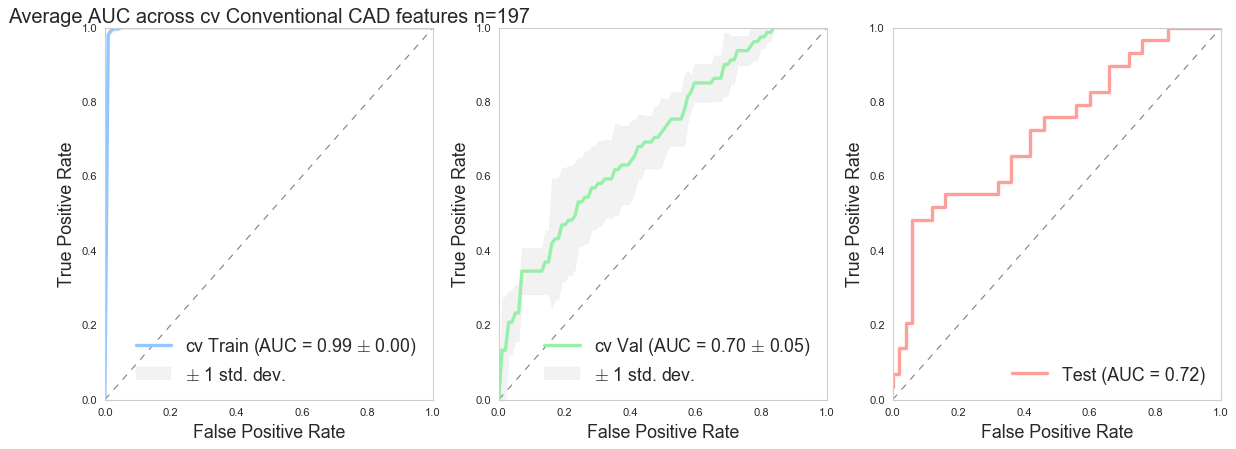

In [27]:
###############################################
## plot ROC curves: 2 ways, Average AUC across cv or from pooled data
###############################################
## Way One: Average AUC across cv
# plot for cv Train       
figROCs = plt.figure(figsize=(18,6))
axaroc_train = figROCs.add_subplot(1,3,1)
# add 50% or chance line
axaroc_train.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr, mean_tpr_train)
std_auc_train = np.std(cvAUC_train)
axaroc_train.plot(mean_fpr, mean_tpr_train, color='b',
         label=r'cv Train (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_train, std_auc_train),lw=3, alpha=1) 
# to add std
std_tpr_train = np.std(tprs_train, axis=0)
tprs_upper = np.minimum(mean_tpr_train + std_tpr_train, 1)
tprs_lower = np.maximum(mean_tpr_train - std_tpr_train, 0)
axaroc_train.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1, label=r'$\pm$ 1 std. dev.')
# set labels
axaroc_train.set_xlabel('False Positive Rate',fontsize=16)
axaroc_train.set_ylabel('True Positive Rate',fontsize=16)
axaroc_train.set_title('Average AUC across cv Conventional CAD features n={}'.format(X_train.shape[1]),fontsize=18)
axaroc_train.legend(loc="lower right",fontsize=16)
axaroc_train.grid("off")

# plot for cv val
axaroc_val = figROCs.add_subplot(1,3,2)
# add 50% or chance line
axaroc_val.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr, mean_tpr_val)
std_auc_val = np.std(cvAUC_val)
axaroc_val.plot(mean_fpr, mean_tpr_val, color='g',
         label=r'cv Val (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_val, std_auc_val),lw=3, alpha=1) 
# to add std
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower = np.maximum(mean_tpr_val - std_tpr_val, 0)
axaroc_val.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1, label=r'$\pm$ 1 std. dev.')
# set labels
axaroc_val.set_xlabel('False Positive Rate',fontsize=16)
axaroc_val.set_ylabel('True Positive Rate',fontsize=16)
axaroc_val.legend(loc="lower right",fontsize=16)
axaroc_val.grid("off")

# plot AUC on heldout set
axaroc_test = figROCs.add_subplot(1,3,3)
# add 50% or chance line
axaroc_test.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_predTest[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc_test.plot(fpr_test, tpr_test, color='r',
            label=r'Test (AUC = %0.2f)' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc_test.set_xlabel('False Positive Rate',fontsize=16)
axaroc_test.set_ylabel('True Positive Rate',fontsize=16)
axaroc_test.legend(loc="lower right",fontsize=16)
axaroc_test.grid("off")


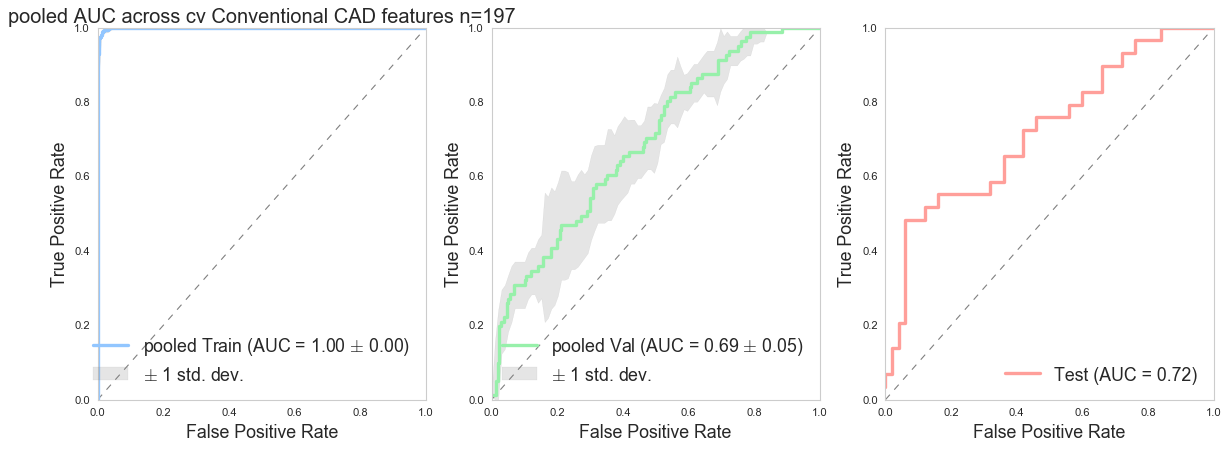

In [8]:
## Way Two: from pooled data
# plot for cv Train       
figROCs = plt.figure(figsize=(18,6))
axaroc_train = figROCs.add_subplot(1,3,1)
# add 50% or chance line
axaroc_train.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot +- 1 -std as fill area
pool_auc_train = auc(pool_fpr_train, pool_tpr_train)
std_auc_train = np.std(cvAUC_train)
axaroc_train.plot(pool_fpr_train, pool_tpr_train, color='b',
            label=r'pooled Train (AUC = %0.2f $\pm$ %0.2f)' % (pool_auc_train, std_auc_train),lw=3, alpha=1)  
# to add std neet wo interpolate
pool_tpr_train100 = interp(mean_fpr, pool_fpr_train, pool_tpr_train)
std_tpr = np.std(tprs_train, axis=0)
tprs_upper = np.minimum(pool_tpr_train100 + std_tpr, 1)
tprs_lower = np.maximum(pool_tpr_train100 - std_tpr, 0)
axaroc_train.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.') 
# set labels
axaroc_train.set_xlabel('False Positive Rate',fontsize=16)
axaroc_train.set_ylabel('True Positive Rate',fontsize=16)
axaroc_train.set_title('pooled AUC across cv Conventional CAD features n={}'.format(X_train.shape[1]),fontsize=18)
axaroc_train.legend(loc="lower right",fontsize=16)
axaroc_train.grid("off")

# plot for cv val
axaroc_val = figROCs.add_subplot(1,3,2)
# add 50% or chance line
axaroc_val.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
pool_auc_val = auc(pool_fpr_val, pool_tpr_val)
std_auc_val = np.std(cvAUC_val)
axaroc_val.plot(pool_fpr_val, pool_tpr_val, color='g',
            label=r'pooled Val (AUC = %0.2f $\pm$ %0.2f)' % (pool_auc_val, std_auc_val),lw=3, alpha=1)     
# to add std neet wo interpolate
pool_tpr_val100 = interp(mean_fpr, pool_fpr_val, pool_tpr_val)
std_tpr = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(pool_tpr_val100 + std_tpr, 1)
tprs_lower = np.maximum(pool_tpr_val100 - std_tpr, 0)
axaroc_val.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.') 
# set labels
axaroc_val.set_xlabel('False Positive Rate',fontsize=16)
axaroc_val.set_ylabel('True Positive Rate',fontsize=16)
axaroc_val.legend(loc="lower right",fontsize=16)
axaroc_val.grid("off")

# plot AUC on heldout set
axaroc_test = figROCs.add_subplot(1,3,3)
# add 50% or chance line
axaroc_test.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_predTest[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc_test.plot(fpr_test, tpr_test, color='r',
            label=r'Test (AUC = %0.2f)' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc_test.set_xlabel('False Positive Rate',fontsize=16)
axaroc_test.set_ylabel('True Positive Rate',fontsize=16)
axaroc_test.legend(loc="lower right",fontsize=16)
axaroc_test.grid("off")

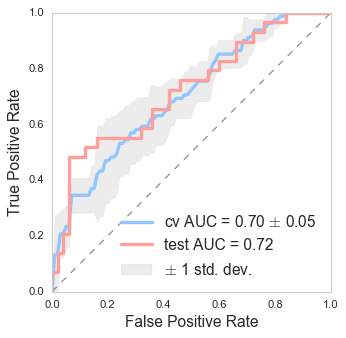

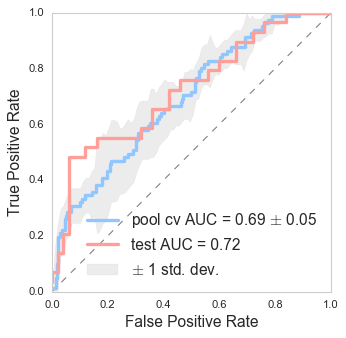

In [28]:
################
# plot for cv val+test in one
################
## Way One: Average AUC across cv
figROCs = plt.figure(figsize=(4.5,4.5))
axaroc = figROCs.add_subplot(1,1,1)
# add 50% or chance line
axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr, mean_tpr_val)
std_auc_val = np.std(cvAUC_val)
axaroc.plot(mean_fpr, mean_tpr_val, color='b',
         label=r'cv AUC = %0.2f $\pm$ %0.2f' % (mean_auc_val, std_auc_val),lw=3, alpha=1) 
# to add std
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower = np.maximum(mean_tpr_val - std_tpr_val, 0)
axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15, label=r'$\pm$ 1 std. dev.')
# plot AUC on heldout set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_predTest[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r',
            label=r'test AUC = %0.2f' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc.set_xlabel('False Positive Rate',fontsize=14)
axaroc.set_ylabel('True Positive Rate',fontsize=14)
axaroc.legend(loc="lower right",fontsize=14)
axaroc.grid("off")


## Way Two: from pooled data
figROCs = plt.figure(figsize=(4.5,4.5))
axaroc = figROCs.add_subplot(1,1,1)
# add 50% or chance line
axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
pool_auc_val = auc(pool_fpr_val, pool_tpr_val)
std_auc_val = np.std(cvAUC_val)
axaroc.plot(pool_fpr_val, pool_tpr_val, color='b',
            label=r'pool cv AUC = %0.2f $\pm$ %0.2f' % (pool_auc_val, std_auc_val),lw=3, alpha=1)     
# to add std neet wo interpolate
pool_tpr_val100 = interp(mean_fpr, pool_fpr_val, pool_tpr_val)
std_tpr = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(pool_tpr_val100 + std_tpr, 1)
tprs_lower = np.maximum(pool_tpr_val100 - std_tpr, 0)
axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15,label=r'$\pm$ 1 std. dev.') 
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_predTest[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r',
            label=r'test AUC = %0.2f' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc.set_xlabel('False Positive Rate',fontsize=14)
axaroc.set_ylabel('True Positive Rate',fontsize=14)
axaroc.legend(loc="lower right",fontsize=14)
axaroc.grid("off")

# Adding graph features

In [29]:
######### 3) train/test splits (test is 10% of labeled data)
# remove unlabeled 
X = combX_allNME[YnxG_allNME[1]!='U']
y = np.asarray(YnxG_allNME[1][YnxG_allNME[1]!='U']=='M').astype(int)

sep = int(combX_allNME.shape[0]*0.10)
X_test = X[:sep]
y_test = y[:sep]
X_train = X[sep:]
y_train = y[sep:]
batch_size = 125 # 160 32*5 = update_interval*5
X_test[np.isnan(X_test)] = 0.00001


## random search of optimal params

In [11]:
######################################################################### for random search
# build a classifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from time import time

clf = RandomForestClassifier()

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"n_estimators": [20,50,100,250,500],
              "max_depth": [3,5,10,None],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)


RandomizedSearchCV took 47.73 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.768 (std: 0.008)
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 100, 'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': 5}

Model with rank: 2
Mean validation score: 0.755 (std: 0.009)
Parameters: {'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 500, 'criterion': 'entropy', 'min_samples_split': 9, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.752 (std: 0.016)
Parameters: {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 500, 'criterion': 'entropy', 'min_samples_split': 6, 'max_depth': None}



In [30]:
######################################################################### for grid parameters
gn_estimators= [20,50,100,250,500]
gmax_depth = [3,10]
gmin_samples_split = [3, 9]
gmin_samples_leaf= [3, 6]

grd = np.array([(d, T, ss, sl) 
            for d in gmax_depth for T in gn_estimators 
            for ss in gmin_samples_split 
            for sl in gmin_samples_leaf ])

grdperf_wnxG = pd.DataFrame(grd)
grdperf_wnxG.columns = ["D","ntrees","min_samples_split","min_samples_leaf"]
grdperf_wnxG['avaucTrain']=0
grdperf_wnxG['stdTrain']=0
grdperf_wnxG['avaucVal']=0
grdperf_wnxG['stdVal']=0
grdperf_wnxG['auctest']=0

# Evaluate a score by cross-validation
sns.set_style("whitegrid")
sns.set_color_codes("pastel")

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5, random_state=3)
for k in range(len(grdperf_wnxG)):  
    # get grid search cell
    #print(grdperf_wnxG.iloc[k])
    D=grdperf_wnxG["D"].iloc[k]
    ntrees=grdperf_wnxG["ntrees"].iloc[k]
    min_ss=grdperf_wnxG["min_samples_split"].iloc[k]
    min_sl=grdperf_wnxG["min_samples_leaf"].iloc[k]
    # Build in l
    cvAUC_train = []
    cvAUC_val = []
    cvAUC_test = []
    cvi = 0
    for train, val in cv.split(X_train, y_train):
        RFmodel = RandomForestClassifier(bootstrap=True,
                                         criterion='gini',
                                         n_estimators=ntrees,
                                         max_depth=D,
                                         min_samples_split= min_ss,
                                         min_samples_leaf= min_sl,
                                         n_jobs=2, random_state=0, verbose=0)
        # run feature selection
        RF = RFmodel.fit(X_train[train], y_train[train])
        ind_featImp = np.argsort(RF.feature_importances_)[::-1]
        RFvarImp = ind_featImp[np.sort(RF.feature_importances_)[::-1]>0.0]
        # top 20% features only = 523*0.20
        varDiscrim = X_train[:,RFvarImp]
    
        RF = RFmodel.fit(varDiscrim[train], y_train[train])
        probas_train = RF.predict_proba(varDiscrim[train])
        probas_val = RF.predict_proba(varDiscrim[val])
        # do in test
        probas_test = RF.predict_proba( X_test[:,RFvarImp] )
        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:, 1])
        auctest = auc(fpr_test, tpr_test)
        # Compute ROC curve and area the curve
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train[train], probas_train[:, 1])
        fpr_val, tpr_val, thresholds_val = roc_curve(y_train[val], probas_val[:, 1])
        # auc
        cvAUC_train.append( auc(fpr_train, tpr_train) )
        cvAUC_val.append( auc(fpr_val, tpr_val) )
        cvAUC_test.append(auctest)
        print "ROC_train$auc = {}".format(cvAUC_train[cvi])
        print "ROC_val$auc = {}".format(cvAUC_val[cvi])
        cvi += 1
    grdperf_wnxG["avaucTrain"].iloc[k] = np.mean(cvAUC_train)
    grdperf_wnxG["stdTrain"].iloc[k] = np.std(cvAUC_train)
    grdperf_wnxG["avaucVal"].iloc[k] = np.mean(cvAUC_val)
    grdperf_wnxG["stdVal"].iloc[k] = np.std(cvAUC_val)
    grdperf_wnxG["auctest"].iloc[k] = np.mean(cvAUC_test)
    
# print
print(grdperf_wnxG)

ROC_train$auc = 0.898663294798
ROC_val$auc = 0.790106951872
ROC_train$auc = 0.876522899066
ROC_val$auc = 0.725852272727
ROC_train$auc = 0.926967285588
ROC_val$auc = 0.603197674419
ROC_train$auc = 0.885057471264
ROC_val$auc = 0.603197674419
ROC_train$auc = 0.900795755968
ROC_val$auc = 0.63226744186
ROC_train$auc = 0.899295520231
ROC_val$auc = 0.663101604278
ROC_train$auc = 0.885993775011
ROC_val$auc = 0.713068181818
ROC_train$auc = 0.897082228117
ROC_val$auc = 0.553779069767
ROC_train$auc = 0.889213085765
ROC_val$auc = 0.626453488372
ROC_train$auc = 0.855172413793
ROC_val$auc = 0.648255813953
ROC_train$auc = 0.908914378613
ROC_val$auc = 0.692513368984
ROC_train$auc = 0.904135171187
ROC_val$auc = 0.705965909091
ROC_train$auc = 0.906542882405
ROC_val$auc = 0.610465116279
ROC_train$auc = 0.906189213086
ROC_val$auc = 0.65261627907
ROC_train$auc = 0.892396109637
ROC_val$auc = 0.626453488372
ROC_train$auc = 0.899295520231
ROC_val$auc = 0.663101604278
ROC_train$auc = 0.885993775011
ROC_val$auc

In [31]:
################
# select best grid parameters
index = grdperf_wnxG[grdperf_wnxG["avaucVal"] == max(grdperf_wnxG["avaucVal"])]
print(index)
Dmax = index["D"].iloc[0]
nTmax = index["ntrees"].iloc[0]
min_ssmax = index["min_samples_split"].iloc[0]
min_slmax = index["min_samples_leaf"].iloc[0]

     D  ntrees  min_samples_split  min_samples_leaf  avaucTrain  stdTrain  \
29  10     100                  3                 6    0.992293  0.001507   
31  10     100                  9                 6    0.992293  0.001507   

    avaucVal    stdVal   auctest  
29  0.690043  0.055342  0.674069  
31  0.690043  0.055342  0.674069  


In [32]:
# Train on best paparms
maxG = []
RFvarImp_E = []
# to pool data
train_pr=pd.DataFrame()
val_pr=pd.DataFrame()
tprs_train = []; cvAUC_train=[]
tprs_val = []; cvAUC_val=[]
cvi = 0
mean_fpr = np.linspace(0, 1, 100)
for train, val in cv.split(X_train, y_train):
    RFmodel = RandomForestClassifier(bootstrap=True,
                                     criterion='gini',
                                     n_estimators=nTmax,
                                     max_depth=Dmax,
                                     min_samples_split= min_ssmax,
                                     min_samples_leaf= min_slmax,
                                     n_jobs=2, random_state=0, verbose=0)
    # run feature selection
    RF = RFmodel.fit(X_train[train], y_train[train])
    ind_featImp = np.argsort(RF.feature_importances_)[::-1]
    RFvarImp = ind_featImp[np.sort(RF.feature_importances_)[::-1]>0.0]
    # top 20% features only = 523*0.20
    varDiscrim = X_train[:,RFvarImp]
    
    RF = RFmodel.fit(varDiscrim[train], y_train[train])
    probas_train = RF.predict_proba(varDiscrim[train])
    probas_val = RF.predict_proba(varDiscrim[val])
    # Compute ROC curve and area the curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train[train], probas_train[:, 1])
    fpr_val, tpr_val, thresholds_val = roc_curve(y_train[val], probas_val[:, 1])
    # auc
    cvAUC_train.append( auc(fpr_train, tpr_train) )
    cvAUC_val.append( auc(fpr_val, tpr_val) )
    print "ROC_train$auc = {}".format(cvAUC_train[cvi])
    print "ROC_val$auc = {}".format(cvAUC_val[cvi])
    cvi += 1
    # append
    train_pr = train_pr.append( pd.DataFrame({"label":y_train[train],"C":probas_train[:,1]}) )
    val_pr = val_pr.append( pd.DataFrame({"label":y_train[val],"C":probas_val[:,1]}) )
    tprs_train.append(interp(mean_fpr, fpr_train, tpr_train))
    tprs_val.append(interp(mean_fpr, fpr_val, tpr_val))
    tprs_train[-1][0] = 0.0; tprs_val[-1][0] = 0.0;
    # collect ensembel
    maxG.append( RF )
    RFvarImp_E.append(RFvarImp)


    # # predict and evaluate performance
# on pool data during cv
pool_fpr_train, pool_tpr_train, pool_thresholds_train = roc_curve(train_pr['label'], train_pr['C'])
pool_fpr_val, pool_tpr_val, pool_thresholds_val = roc_curve(val_pr['label'], val_pr['C'])

# assess on held out test
ensemble_predTest = np.zeros((X_test.shape[0],2))
for cvi in range(5):
    ensemble_predTest = ensemble_predTest + maxG[cvi].predict_proba(X_test[:,RFvarImp_E[cvi]])

ensemble_predTest = ensemble_predTest/5.0


ROC_train$auc = 0.989974710983
ROC_val$auc = 0.707219251337
ROC_train$auc = 0.993152512228
ROC_val$auc = 0.738636363636
ROC_train$auc = 0.991865605659
ROC_val$auc = 0.594476744186
ROC_train$auc = 0.994518125553
ROC_val$auc = 0.744186046512
ROC_train$auc = 0.991954022989
ROC_val$auc = 0.665697674419


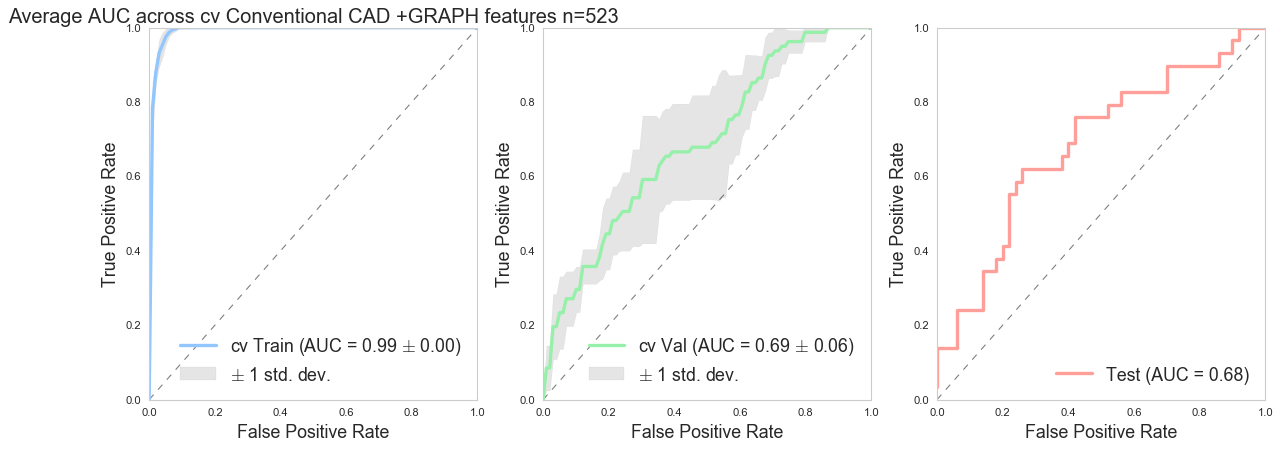

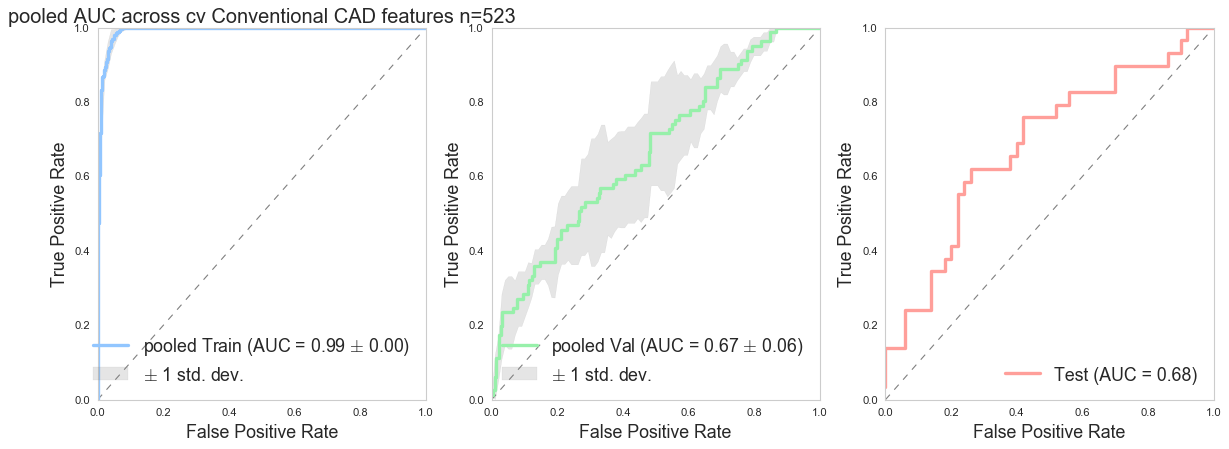

In [33]:
###############################################
## plot ROC curves: 2 ways, Average AUC across cv or from pooled data
###############################################
## Way One: Average AUC across cv
# plot for cv Train       
figROCs = plt.figure(figsize=(18,6))
axaroc_train = figROCs.add_subplot(1,3,1)
# add 50% or chance line
axaroc_train.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr, mean_tpr_train)
std_auc_train = np.std(cvAUC_train)
axaroc_train.plot(mean_fpr, mean_tpr_train, color='b',
         label=r'cv Train (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_train, std_auc_train),lw=3, alpha=1) 
# to add std
std_tpr_train = np.std(tprs_train, axis=0)
tprs_upper = np.minimum(mean_tpr_train + std_tpr_train, 1)
tprs_lower = np.maximum(mean_tpr_train - std_tpr_train, 0)
axaroc_train.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
# set labels
axaroc_train.set_xlabel('False Positive Rate',fontsize=16)
axaroc_train.set_ylabel('True Positive Rate',fontsize=16)
axaroc_train.set_title('Average AUC across cv Conventional CAD +GRAPH features n={}'.format(X_train.shape[1]),fontsize=18)
axaroc_train.legend(loc="lower right",fontsize=16)
axaroc_train.grid("off")

# plot for cv val
axaroc_val = figROCs.add_subplot(1,3,2)
# add 50% or chance line
axaroc_val.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr, mean_tpr_val)
std_auc_val = np.std(cvAUC_val)
axaroc_val.plot(mean_fpr, mean_tpr_val, color='g',
         label=r'cv Val (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_val, std_auc_val),lw=3, alpha=1) 
# to add std
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower = np.maximum(mean_tpr_val - std_tpr_val, 0)
axaroc_val.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
# set labels
axaroc_val.set_xlabel('False Positive Rate',fontsize=16)
axaroc_val.set_ylabel('True Positive Rate',fontsize=16)
axaroc_val.legend(loc="lower right",fontsize=16)
axaroc_val.grid("off")

# plot AUC on heldout set
axaroc_test = figROCs.add_subplot(1,3,3)
# add 50% or chance line
axaroc_test.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_predTest[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc_test.plot(fpr_test, tpr_test, color='r',
            label=r'Test (AUC = %0.2f)' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc_test.set_xlabel('False Positive Rate',fontsize=16)
axaroc_test.set_ylabel('True Positive Rate',fontsize=16)
axaroc_test.legend(loc="lower right",fontsize=16)
axaroc_test.grid("off")


## Way Two: from pooled data
# plot for cv Train       
figROCs = plt.figure(figsize=(18,6))
axaroc_train = figROCs.add_subplot(1,3,1)
# add 50% or chance line
axaroc_train.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot +- 1 -std as fill area
pool_auc_train = auc(pool_fpr_train, pool_tpr_train)
std_auc_train = np.std(cvAUC_train)
axaroc_train.plot(pool_fpr_train, pool_tpr_train, color='b',
            label=r'pooled Train (AUC = %0.2f $\pm$ %0.2f)' % (pool_auc_train, std_auc_train),lw=3, alpha=1)  
# to add std neet wo interpolate
pool_tpr_train100 = interp(mean_fpr, pool_fpr_train, pool_tpr_train)
std_tpr = np.std(tprs_train, axis=0)
tprs_upper = np.minimum(pool_tpr_train100 + std_tpr, 1)
tprs_lower = np.maximum(pool_tpr_train100 - std_tpr, 0)
axaroc_train.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.') 
# set labels
axaroc_train.set_xlabel('False Positive Rate',fontsize=16)
axaroc_train.set_ylabel('True Positive Rate',fontsize=16)
axaroc_train.set_title('pooled AUC across cv Conventional CAD features n={}'.format(X_train.shape[1]),fontsize=18)
axaroc_train.legend(loc="lower right",fontsize=16)
axaroc_train.grid("off")

# plot for cv val
axaroc_val = figROCs.add_subplot(1,3,2)
# add 50% or chance line
axaroc_val.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
pool_auc_val = auc(pool_fpr_val, pool_tpr_val)
std_auc_val = np.std(cvAUC_val)
axaroc_val.plot(pool_fpr_val, pool_tpr_val, color='g',
            label=r'pooled Val (AUC = %0.2f $\pm$ %0.2f)' % (pool_auc_val, std_auc_val),lw=3, alpha=1)     
# to add std neet wo interpolate
pool_tpr_val100 = interp(mean_fpr, pool_fpr_val, pool_tpr_val)
std_tpr = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(pool_tpr_val100 + std_tpr, 1)
tprs_lower = np.maximum(pool_tpr_val100 - std_tpr, 0)
axaroc_val.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.') 
# set labels
axaroc_val.set_xlabel('False Positive Rate',fontsize=16)
axaroc_val.set_ylabel('True Positive Rate',fontsize=16)
axaroc_val.legend(loc="lower right",fontsize=16)
axaroc_val.grid("off")

# plot AUC on heldout set
axaroc_test = figROCs.add_subplot(1,3,3)
# add 50% or chance line
axaroc_test.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_predTest[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc_test.plot(fpr_test, tpr_test, color='r',
            label=r'Test (AUC = %0.2f)' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc_test.set_xlabel('False Positive Rate',fontsize=16)
axaroc_test.set_ylabel('True Positive Rate',fontsize=16)
axaroc_test.legend(loc="lower right",fontsize=16)
axaroc_test.grid("off")

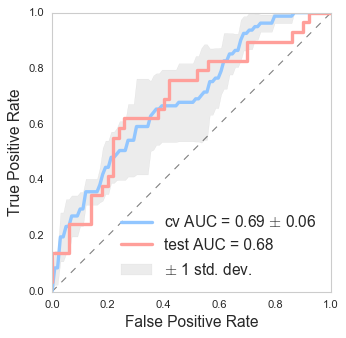

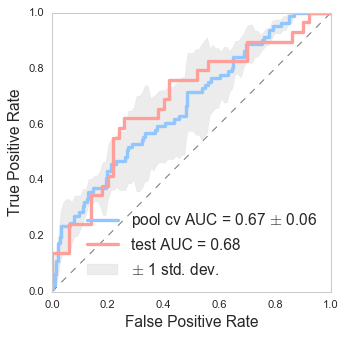

In [34]:
################
# plot for cv val+test in one
################
## Way One: Average AUC across cv
figROCs = plt.figure(figsize=(4.5,4.5))
axaroc = figROCs.add_subplot(1,1,1)
# add 50% or chance line
axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr, mean_tpr_val)
std_auc_val = np.std(cvAUC_val)
axaroc.plot(mean_fpr, mean_tpr_val, color='b',
         label=r'cv AUC = %0.2f $\pm$ %0.2f' % (mean_auc_val, std_auc_val),lw=3, alpha=1) 
# to add std
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower = np.maximum(mean_tpr_val - std_tpr_val, 0)
axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15, label=r'$\pm$ 1 std. dev.')
# plot AUC on heldout set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_predTest[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r',
            label=r'test AUC = %0.2f' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc.set_xlabel('False Positive Rate',fontsize=14)
axaroc.set_ylabel('True Positive Rate',fontsize=14)
axaroc.legend(loc="lower right",fontsize=14)
axaroc.grid("off")


## Way Two: from pooled data
figROCs = plt.figure(figsize=(4.5,4.5))
axaroc = figROCs.add_subplot(1,1,1)
# add 50% or chance line
axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
pool_auc_val = auc(pool_fpr_val, pool_tpr_val)
std_auc_val = np.std(cvAUC_val)
axaroc.plot(pool_fpr_val, pool_tpr_val, color='b',
            label=r'pool cv AUC = %0.2f $\pm$ %0.2f' % (pool_auc_val, std_auc_val),lw=3, alpha=1)     
# to add std neet wo interpolate
pool_tpr_val100 = interp(mean_fpr, pool_fpr_val, pool_tpr_val)
std_tpr = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(pool_tpr_val100 + std_tpr, 1)
tprs_lower = np.maximum(pool_tpr_val100 - std_tpr, 0)
axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15,label=r'$\pm$ 1 std. dev.') 
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, ensemble_predTest[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r',
            label=r'test AUC = %0.2f' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc.set_xlabel('False Positive Rate',fontsize=14)
axaroc.set_ylabel('True Positive Rate',fontsize=14)
axaroc.legend(loc="lower right",fontsize=14)
axaroc.grid("off")


## Hyperparameter plots

(0.5, 1.05)

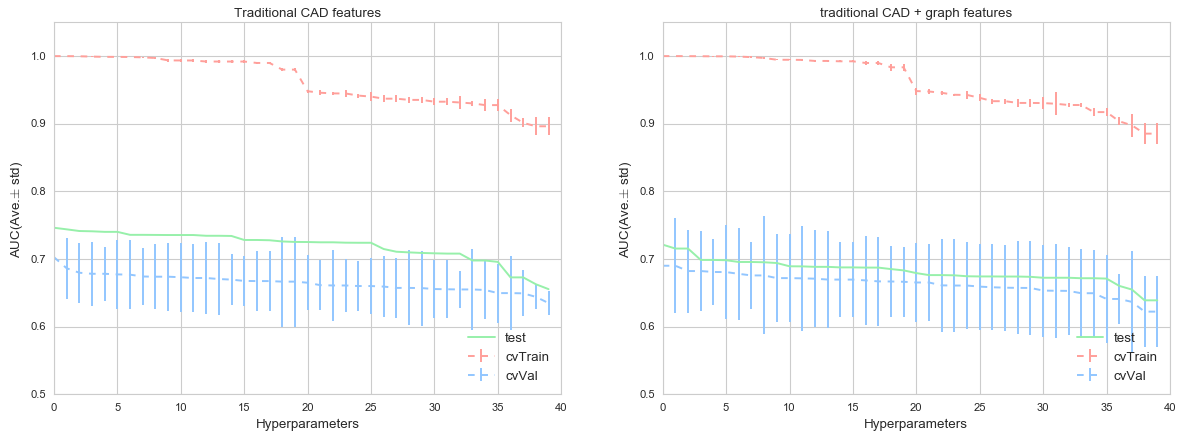

In [36]:
###########################################
# plot hyperparameter plots
############################################
num_hyp= range(len(grdperf_RF["avaucTrain"]))
figHyperp = plt.figure(figsize=(18,6))
axs1 = figHyperp.add_subplot(1,2,1)
axs2 = figHyperp.add_subplot(1,2,2)

# for cvAUC train
sortauc_Train = grdperf_RF.sort_values(by='avaucTrain',ascending=False)
# for cvAUC val
sortauc_Val = grdperf_RF.sort_values(by='avaucVal',ascending=False)
sortauc_test = grdperf_RF.sort_values(by='auctest',ascending=False)

# plot
axs1.errorbar(x=num_hyp, y=sortauc_Train['avaucTrain'].values, 
              yerr=sortauc_Train["stdTrain"].values, fmt='--r', label='cvTrain')
axs1.errorbar(x=num_hyp, y=sortauc_Val['avaucVal'].values, 
              yerr=sortauc_Train["stdVal"].values, fmt='--b', label='cvVal')
axs1.plot(num_hyp, sortauc_test['auctest'].values, 'g', label='test')
axs1.set_title('Traditional CAD features',fontsize=12)
axs1.set_xlabel('Hyperparameters',fontsize=12)
axs1.set_ylabel('AUC(Ave.$\pm$ std)',fontsize=12)
axs1.legend(loc="lower right",fontsize=12)
axs1.set_ylim(0.5,1.05)

# for cvAUC train wiht NXG ffeatures
sortauc_Train = grdperf_wnxG.sort_values(by='avaucTrain',ascending=False)
# for cvAUC val
sortauc_Val = grdperf_wnxG.sort_values(by='avaucVal',ascending=False)
sortauc_test = grdperf_wnxG.sort_values(by='auctest',ascending=False)

# plot
axs2.errorbar(x=num_hyp, y=sortauc_Train['avaucTrain'].values, 
              yerr=sortauc_Train["stdTrain"].values, fmt='--r', label='cvTrain')
axs2.errorbar(x=num_hyp, y=sortauc_Val['avaucVal'].values, 
              yerr=sortauc_Train["stdVal"].values, fmt='--b', label='cvVal')
axs2.plot(num_hyp, sortauc_test['auctest'].values, 'g', label='test')
axs2.set_title('traditional CAD + graph features',fontsize=12)
axs2.set_xlabel('Hyperparameters',fontsize=12)
axs2.set_ylabel('AUC(Ave.$\pm$ std)',fontsize=12)
axs2.legend(loc="lower right",fontsize=12)
axs2.set_ylim(0.5,1.05)

In [35]:
########################################################################################### OR
traditional_CAD = r'Z:\Cristina\Section3\paper_notes\comparison_traditionalCAD'

# combine in one dataframe and sve
grdperf_RF["type"] = "trad_RF"
grdperf_wnxG["type"] = "tradwnxG_RF"
grdperf_comb = pd.DataFrame(grdperf_RF.append(grdperf_wnxG))
grdperf_comb.to_csv(os.path.join(traditional_CAD,'grdperf_comb.csv'), sep=',', encoding='utf-8', header=True, index=False)

grdperf_RF = grdperf_comb[grdperf_comb["type"]=='trad_RF']
grdperf_wnxG = grdperf_comb[grdperf_comb["type"]=='tradwnxG_RF']